In [1]:
import numpy as np
from numpy.linalg.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeaturel
import pandas as pd

In [19]:
seed = [ 8, 15, 16,  0, 19,  0,  0, 19, 12,  7,
         1, 19, 18, 17, 17,  2,  7, 16, 18, 16,
        16, 15, 16, 16, 12, 13, 19, 19, 18, 18, 
        18, 13, 15, 18, 18, 18]
lt_max = len(seed)
tt = 30

df  = np.load(f'/work/gi55/i55233/data/results/bsiso_shap/jja_{(tt):03}day.npz')
df2 = np.load(f'/work/gi55/i55233/data/machine_learning/results/kikuchi-8vals_v1/cor/8vals/{(tt):03}day/seed{(seed[tt]):03}.npz')
shap_values = df['shap_values']
pred = df2['arr_0'][:-1-(lt_max-tt)] # 対応する pred の値

print(shap_values.shape)
print(pred.shape)

(2, 644, 25, 144, 24)
(2519, 2)


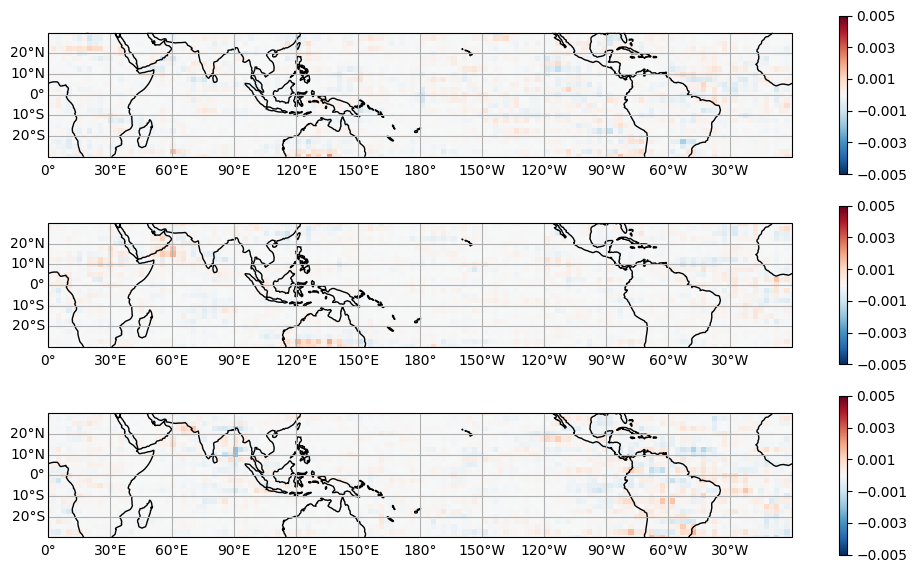

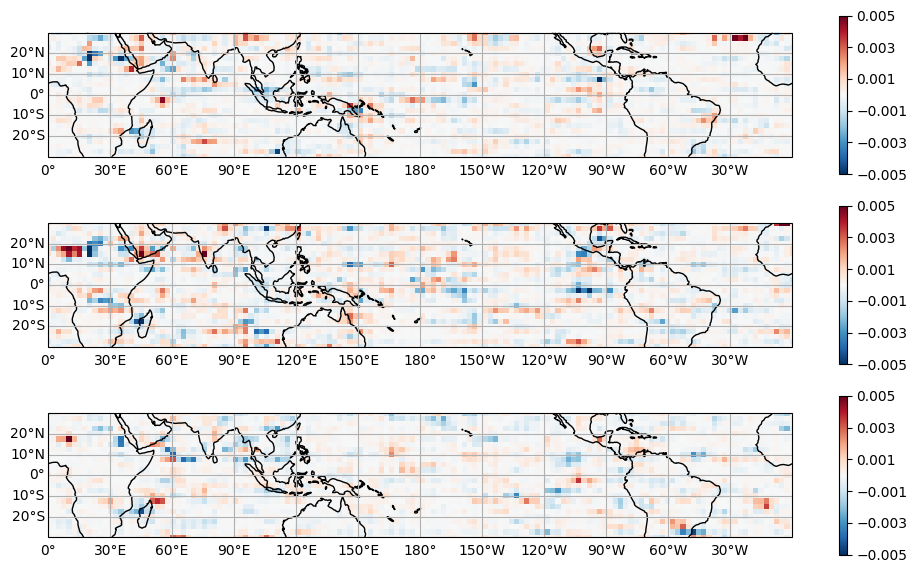

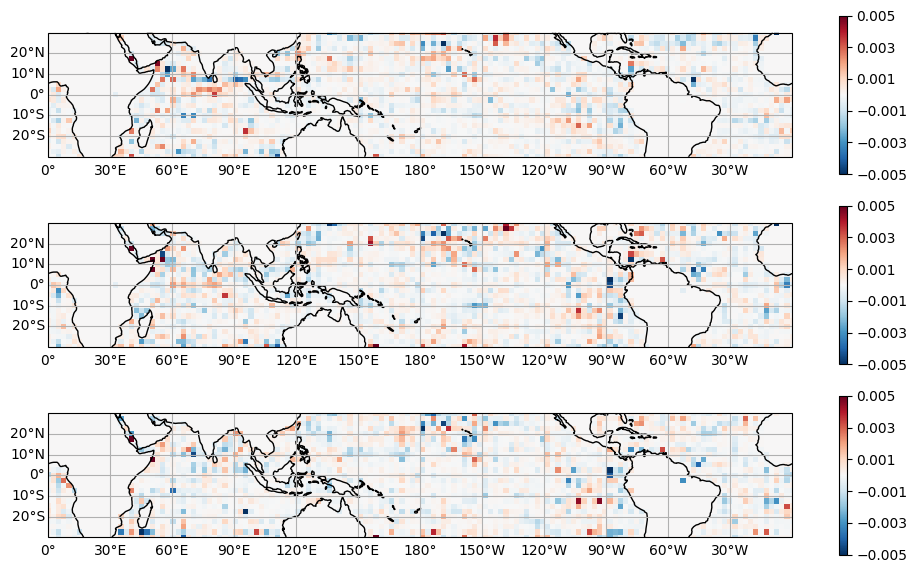

In [20]:
name_box = ['OLR', 'U WIND', 'V UIND']
for jj in range(5,8):
  fig = plt.figure(figsize=(12,7))
  for cc in range(3):
    ax=fig.add_subplot(3,1,cc+1, projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False     # 上部の経度のラベルを消去
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30)) # 経度線
    gl.ylocator = mticker.FixedLocator(np.arange(-30, 30, 10)) # 緯度線
    ax.coastlines()

    lon = np.linspace(0, 360, 144)
    lat = np.linspace(30, -30, 25)
    x, y = np.meshgrid(lon-180.0, lat) # 経度、緯度データ
    cntr = ax.pcolormesh(x, y, shap_values[1,100,:,:,3*jj+cc], vmax=0.005, vmin=-0.005, cmap='RdBu_r')
    #cntr = ax.contourf(x, y, shap_values[1,100,:,:,3*jj+cc], np.linspace(-0.005, 0.005), cmap='RdBu_r', extend='both')
    cbar = fig.colorbar(cntr, ticks = np.linspace(-0.005, 0.005, 6), orientation='vertical')
    #ax.set_title('Shaprey Value  ' + str(name_box[jj]))
    ax.axis((-180, 180, -30, 30))
  plt.show()

In [23]:
# ホフメラーダイアグラム
shap_umean = np.sum(shap_values, axis=2)
shap_vmean = np.sum(shap_values, axis=3)

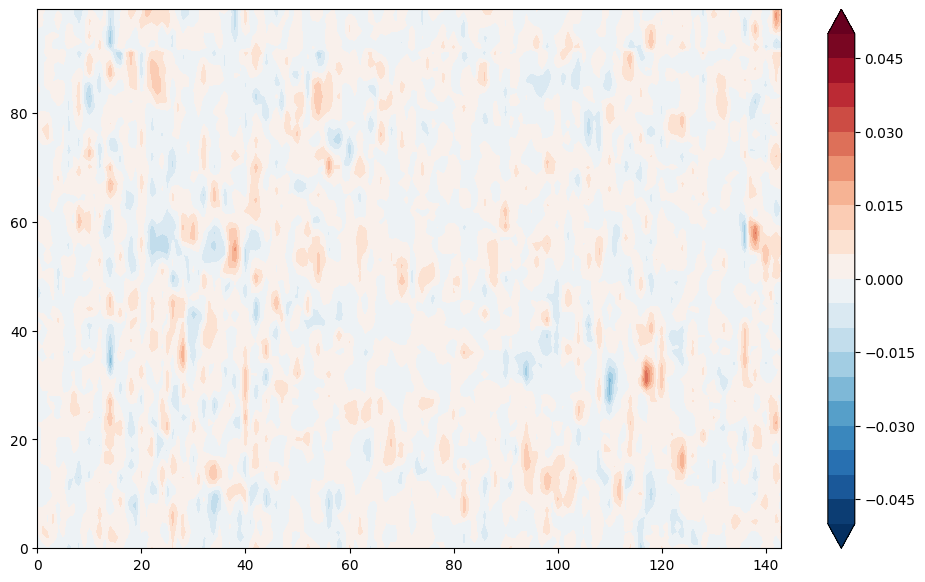

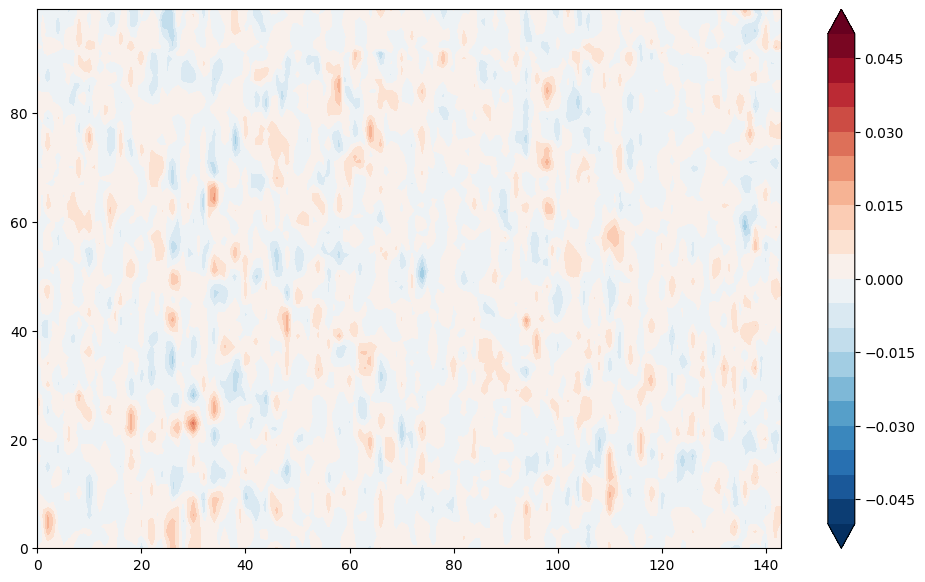

In [28]:
fig = plt.figure(figsize=(12,7))
plt.contourf(shap_umean[1,:100,:,10], np.linspace(-0.05, 0.05, 21), cmap='RdBu_r', extend='both')
plt.colorbar()

fig = plt.figure(figsize=(12,7))
plt.contourf(shap_umean[0,:100,:,10], np.linspace(-0.05, 0.05, 21), cmap='RdBu_r', extend='both')
plt.colorbar()

In [19]:
# データの読み込み

data = np.load('/work/gi55/i55233/data/results/bsiso_eeof/prepro_anomaly_8vals.npz')
print('data = ', data.files)

lat = data['lat'][24:49]
lon = data['lon']
olr = data['olr'][80:,24:49,:]
u850 = data['u850'][80:,24:49,:]
v850 = data['v850'][80:,24:49,:]
u200 = data['u200'][80:,24:49,:]
v200 = data['v200'][80:,24:49,:]
h850 = data['h850'][80:,24:49,:]
pr_wtr = data['pr_wtr'][80:,24:49,:]
sst = data['sst'][80:,24:49,:]
time = data['time'][80:]    # 射影後にデータが10日進むため、時刻の方を前進させておく
real_time = pd.to_datetime(time, unit='h', origin=pd.Timestamp('1800-01-01')) # 時刻をdatetime型に変換
print(lat.shape, lon.shape, olr.shape, u850.shape, v850.shape, u200.shape, v200.shape, h850.shape, pr_wtr.shape)
print(real_time[0], real_time[-1])

# 標準化処理
def normalization(data):
  data_mean = np.mean(data, axis=0)
  data_std  = np.std(data, axis=0)
  data_norm = (data - data_mean) / data_std
  print('Raw Data        = ', data.max(), data.min())
  print('Normalized Data = ', data_norm.max(), data_norm.min())
  data_norm = np.nan_to_num(data_norm, nan=0) # 欠損値(nan)を0で置換
  del data_mean, data_std
  return data_norm

olr_norm  = normalization(olr)
u850_norm = normalization(u850)
v850_norm = normalization(v850)
u200_norm = normalization(u200)
v200_norm = normalization(v200)
h850_norm = normalization(h850)
pr_wtr_norm = normalization(pr_wtr)
sst_norm = normalization(sst)

# bsiso index (eEOF) 読み込み
data_file = '/work/gi55/i55233/data/results/bsiso_eeof/bsiso_rt-PCs.npz'
PC      = np.load(data_file)['rt_PCs'][:,:2]
sign    = np.array([-1, 1]).T
PC_norm = sign * PC / PC.std(axis=0)[np.newaxis,:]
time2   = np.load(data_file)['time']
real_time2 = pd.to_datetime(time2, unit='h', origin=pd.Timestamp('1800-01-01')) # 時刻をdatetime型に変換

print('PCs = ', PC_norm.shape)
print('time PCs= ', time2.shape)
print('real time PCs = ', real_time2[0], real_time2[-1])

# インデクシングする関数
def indexing(lead_time):
  output_shape = 2
  rt = real_time2[:-lead_time-1]
  sup_data = PC_norm[lead_time:]
  print(sup_data.shape)
  idx = np.where((rt.year <= 2015))[0]
  sup_train = sup_data[idx]
  idx = np.where((rt.year > 2015))[0]
  sup_test = sup_data[idx]
  sup_rt = rt[idx]
  print(sup_test.shape, sup_train.shape)
  return data, rt, sup_train, sup_test, output_shape, sup_rt

# 入力データの前処理
def preprocess(data, rt, lead_time):
  ipt_lag0  = data[10:-lead_time-1]
  ipt_lag5  = data[5:-lead_time-6]
  ipt_lag10 = data[:-lead_time-11]

  # 検証データの作成
  idx = np.where((rt.year > 2015))[0]
  ipt_lag0_test = ipt_lag0[idx]
  ipt_lag5_test = ipt_lag5[idx]
  ipt_lag10_test = ipt_lag10[idx]
  ipt_test = np.stack([ipt_lag0_test, ipt_lag5_test, ipt_lag10_test], 3)
  return ipt_test

# ==== iteration program ====
lt_box = [0]
#lt_box = [0, 5, 10, 15, 20, 25, 30, 35]
#lt_box = np.arange(36)
for lead_time in lt_box:

  print('==== lead time : {} day ====='.format(lead_time))

  data, rt, sup_train, sup_test, output_shape, sup_rt = indexing(lead_time) 

  olr_ipt_test = preprocess(olr_norm, rt, lead_time)
  u850_ipt_test = preprocess(u850_norm, rt, lead_time)
  v850_ipt_test = preprocess(v850_norm, rt, lead_time)
  u200_ipt_test = preprocess(u200_norm, rt, lead_time)
  v200_ipt_test = preprocess(v200_norm, rt, lead_time)
  h850_ipt_test = preprocess(h850_norm, rt, lead_time)
  pr_wtr_ipt_test = preprocess(pr_wtr_norm, rt, lead_time)
  sst_ipt_test = preprocess(sst_norm, rt, lead_time)

  ipt_test  = np.concatenate([olr_ipt_test, u850_ipt_test,  u200_ipt_test,
                              v850_ipt_test, v200_ipt_test, h850_ipt_test, 
                              pr_wtr_ipt_test, sst_ipt_test], 3)
  print(ipt_test.shape)


data =  ['lat', 'lon', 'time', 'real_time', 'olr', 'u850', 'v850', 'u200', 'v200', 'h850', 'pr_wtr', 'sst']
(25,) (144,) (15991, 25, 144) (15991, 25, 144) (15991, 25, 144) (15991, 25, 144) (15991, 25, 144) (15991, 25, 144) (15991, 25, 144)
1979-03-22 00:00:00 2022-12-31 00:00:00
Raw Data        =  110.6346296477856 -163.06319252604578
Normalized Data =  8.610244733289218 -15.696228824469003
Raw Data        =  26.628822697430984 -27.39433673019417
Normalized Data =  8.718597179911693 -6.659368241725141
Raw Data        =  19.607371330660023 -21.027599307874095
Normalized Data =  9.371160190483371 -9.169251236677564
Raw Data        =  54.12790452689419 -59.46183253683652
Normalized Data =  6.598683947935241 -8.180679755615591
Raw Data        =  50.62647740730578 -45.80567673624702
Normalized Data =  7.36514770028667 -6.98696916292694
Raw Data        =  132.37072580688695 -196.37969980408127
Normalized Data =  5.4903753314082575 -9.535849081936803
Raw Data        =  36.488246148282585 -32.

/tmp/ipykernel_2259750/1991565507.py:25: RuntimeWarning: invalid value encountered in divide
  data_norm = (data - data_mean) / data_std


Raw Data        =  4.588571921210745 -4.560916137984673
Normalized Data =  nan nan
PCs =  (15981, 2)
time PCs=  (15981,)
real time PCs =  1979-04-01 00:00:00 2022-12-31 00:00:00
==== lead time : 0 day =====
(15981, 2)
(2556, 2) (13424, 2)
(2556, 25, 144, 24)


In [17]:
total1 = shap_values.sum(axis=(2,3,4))
total2 = shap_values.sum(axis=(2,3,4))
print(total1.shape, total2.shape)
print(total1[0,:100])
print(total2[1,:100])

(2, 644) (2, 644)
[-0.31231676 -0.23593335 -0.23107013 -0.39563245 -0.46277148 -0.47304928
 -0.52559738 -0.54622531 -0.40960149 -0.12770313 -0.04322063  0.1480828
  0.48123282  0.95207248  1.31118379  1.6274888   1.77711533  1.80799463
  1.60531924  1.22482036  0.81626512  0.4275165  -0.01709779 -0.48604836
 -0.80833827 -1.20985248 -1.51650688 -1.70787898 -1.81847921 -1.93504773
 -2.08577645 -2.18512209 -2.1861496  -2.10560256 -2.02036736 -1.77058973
 -1.48091744 -1.17246682 -0.79573285 -0.41987575 -0.03115713  0.39279376
  0.81761778  1.22358088  1.55384049  1.7495016   1.99753702  2.14615555
  2.26489659  2.33278126  2.39862156  2.31448769  2.10618318  1.91242371
  1.56195932  1.10401808  0.56409066  0.03570369 -0.33036373 -0.49822351
 -0.65047857 -0.68977868 -0.74122575 -0.81659557 -0.95384454 -1.02884466
 -1.00021416 -0.90036954 -0.79602807 -0.80624694 -0.76536758 -0.66043219
 -0.61409745 -0.56278803 -0.4766752  -0.36374231 -0.26930634 -0.21853333
 -0.15374227 -0.03364316  0.013564

In [20]:
jja = np.where((sup_rt.month >= 6) & (sup_rt.month <= 8) & (sup_rt.year > 2015))[0]
rt = real_time2[jja]
pred_jja = pred[jja]
print(pred_jja.shape)
print(pred_jja[:100])

(644, 2)
[[-0.3609115   0.7596415 ]
 [-0.28452802  0.7133163 ]
 [-0.27966487  0.66159034]
 [-0.44422704  0.5594317 ]
 [-0.5113661   0.63983977]
 [-0.52164423  0.76213706]
 [-0.5741921   0.8716216 ]
 [-0.5948203   1.0880026 ]
 [-0.45819628  1.4616727 ]
 [-0.17629755  1.6315414 ]
 [-0.09181542  1.6584643 ]
 [ 0.09948819  1.6229826 ]
 [ 0.432638    1.579765  ]
 [ 0.9034775   1.4440284 ]
 [ 1.2625891   1.1685126 ]
 [ 1.578894    0.85463595]
 [ 1.7285212   0.43942454]
 [ 1.7594002  -0.15770754]
 [ 1.5567247  -0.8927871 ]
 [ 1.1762261  -1.3959309 ]
 [ 0.7676706  -1.8074635 ]
 [ 0.37892193 -2.0813386 ]
 [-0.06569228 -2.3241425 ]
 [-0.53464305 -2.4927154 ]
 [-0.85693276 -2.4462707 ]
 [-1.2584472  -2.3342967 ]
 [-1.5651015  -2.2053552 ]
 [-1.7564741  -1.9024749 ]
 [-1.8670741  -1.506428  ]
 [-1.9836422  -1.1481125 ]
 [-2.134371   -0.830637  ]
 [-2.233717   -0.44053873]
 [-2.2347443  -0.11062953]
 [-2.1541972   0.20949677]
 [-2.0689626   0.58059704]
 [-1.8191847   0.9368814 ]
 [-1.5295124   1.28

In [21]:
rmse_shap = np.sqrt(np.mean((total1[:,0] - pred_jja[0])**2)) 
print(rmse_shap)

0.05258543974296592


In [22]:
# 相関係数の計算
def culc_cor(test_data, pred_data):
    j = 0
    cor = (np.sum(pred_data[:,2*j] * test_data[:,2*j], axis=0) + np.sum(pred_data[:,2*j+1] * test_data[:,2*j+1], axis=0)) / \
            (np.sqrt(np.sum(pred_data[:,2*j] ** 2 + pred_data[:,2*j+1] ** 2, axis=0)) * np.sqrt(np.sum(test_data[:,2*j] ** 2 + test_data[:,2*j+1] ** 2, axis=0)))
    #print('cor : = ', cor)
    return cor

cor = culc_cor(total1.T, pred_jja)
print(cor)

0.9990033901491006


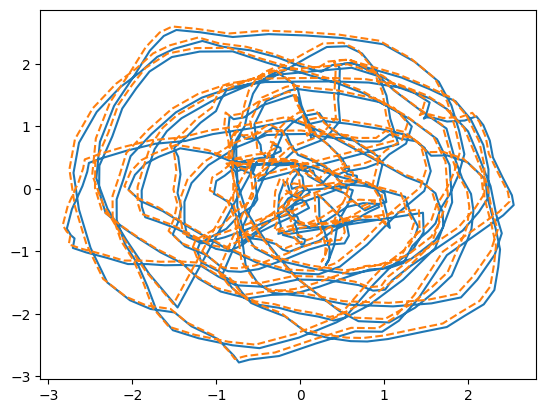

In [23]:
plt.plot(total1[0,:], total1[1,:], linestyle='-')
plt.plot(pred_jja[:,0], pred_jja[:,1], linestyle='--')

## 変数ごとの寄与度の解析

In [21]:
# fructional variance の contribution を計算する
print(shap_values.shape)
shap_variance = np.var(shap_values, axis=(0,1,2,3))
shap_attr = shap_variance / np.sum(np.var(shap_values, axis=(0,1,2,3)))   
print(shap_variance)
print(shap_attr)

(2, 644, 25, 144, 24)
[2.40069761e-07 3.03156845e-07 1.72306036e-07 1.69697987e-07
 2.84449990e-07 2.14141147e-07 1.28397234e-07 1.10244410e-07
 9.83571544e-08 1.66405124e-07 3.32120608e-07 1.73227045e-07
 7.51846359e-08 9.17600344e-08 8.16439249e-08 6.24761546e-08
 3.78281632e-08 4.07367716e-08 2.63148668e-07 4.98707360e-07
 2.43876163e-07 3.85448776e-07 6.55318672e-07 5.31431626e-07]
[0.04478801 0.0565577  0.03214584 0.03165928 0.0530677  0.03995071
 0.02395411 0.02056747 0.01834976 0.03104495 0.06196125 0.03231767
 0.01402663 0.01711898 0.01523169 0.01165571 0.00705732 0.00759995
 0.04909367 0.09304009 0.04549814 0.07191028 0.12225788 0.09914521]


0.13349155143730107


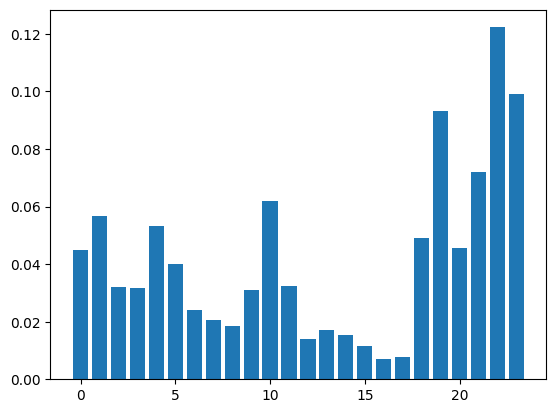

In [22]:
wo_values = ['olr', 'u850', 'v850', 'u200', 'v200', 'h850', 'pr_wtr', 'sst']
plt.bar(np.arange(24), shap_attr)
print(shap_attr[:3].sum())

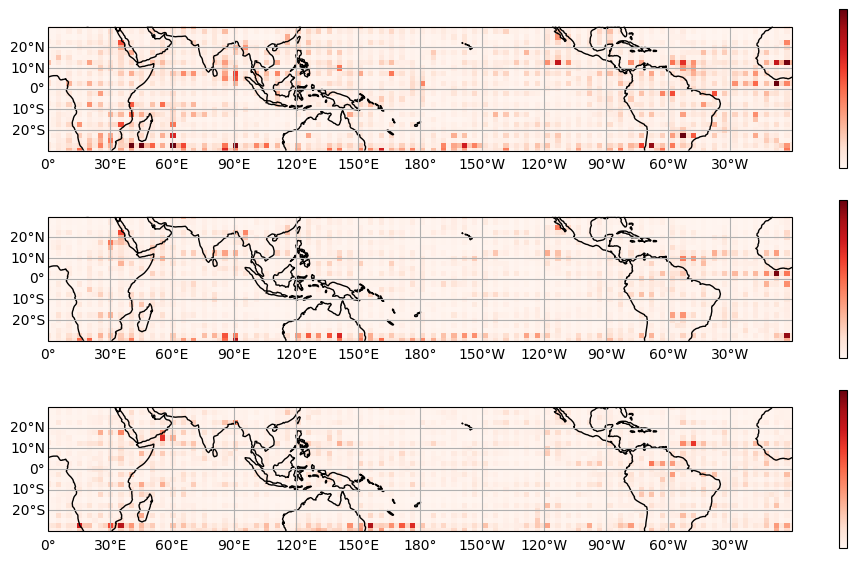

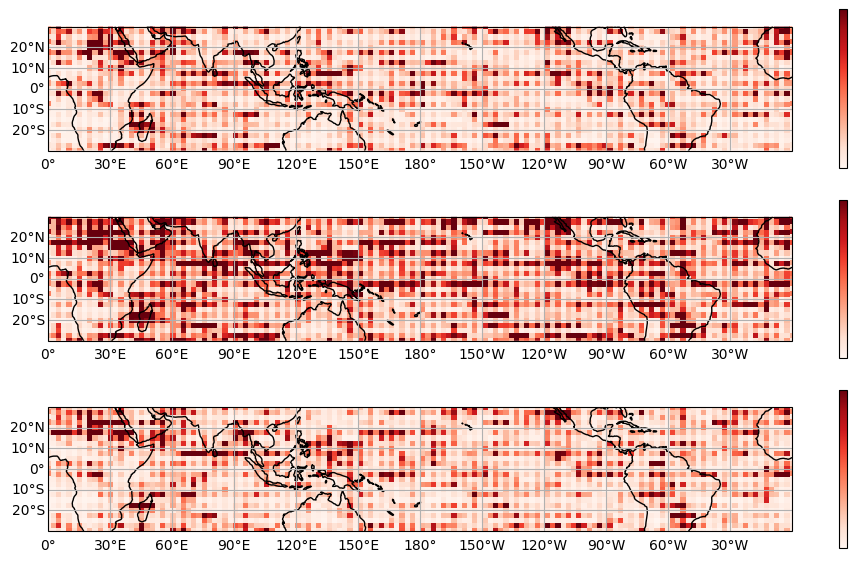

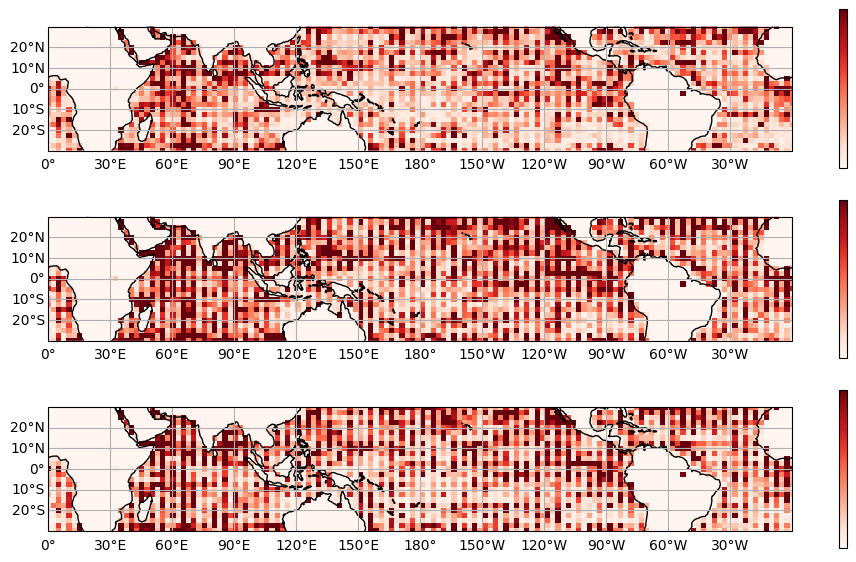

In [39]:
name_box = ['OLR', 'U WIND', 'V UIND']
for jj in range(5,8):
  fig = plt.figure(figsize=(12,7))
  for cc in range(3):
    ax=fig.add_subplot(3,1,cc+1, projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_extent([-180, 180, -30, 30], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.top_labels = False     # 上部の経度のラベルを消去
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30)) # 経度線
    gl.ylocator = mticker.FixedLocator(np.arange(-30, 30, 10)) # 緯度線
    ax.coastlines()

    lon = np.linspace(0, 360, 144)
    lat = np.linspace(30, -30, 25)
    x, y = np.meshgrid(lon-180.0, lat) # 経度、緯度データ
    cntr = ax.pcolormesh(x, y, shap_values[1,:,:,:,3*jj+cc].var(axis=0), vmax=1e-6, vmin=0, cmap='Reds')
    #cntr = ax.contourf(x, y, shap_values[1,100,:,:,3*jj+cc], np.linspace(-0.005, 0.005), cmap='RdBu_r', extend='both')
    cbar = fig.colorbar(cntr, ticks = np.linspace(-0.005, 0.005, 6), orientation='vertical')
    #ax.set_title('Shaprey Value  ' + str(name_box[jj]))
    ax.axis((-180, 180, -30, 30))
  plt.show()